<a href="https://colab.research.google.com/github/ShwetaKulkarni2020/TestGithubAction/blob/main/AirQualityForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pdf2image pytesseract pandas pillow
!apt-get install -y poppler-utils

**AIR QUALITY PARAMETERS DATA IS EXTRACTED FROM KARNATAKA STATE POLLUTION CONTROL BOARD.... CONVERTING PDF IMAGE TO CSV**

In [ ]:
import pytesseract
from pdf2image import convert_from_path
import pandas as pd




# OPTIONAL: Set tesseract path if not in system PATH
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def ocr_pdf_page_to_csv(pdf_path, page_number, csv_output_path):
    # Convert PDF page to image (1-based index)
    images = convert_from_path(pdf_path)
    if page_number < 1 or page_number > len(images):
        raise ValueError("Invalid page number")

    image = images[page_number - 1]

    # Perform OCR on the image
    raw_text = pytesseract.image_to_string(image)

    # Split text into rows
    rows = raw_text.strip().split('\n')
    rows = [row for row in rows if row.strip()]  # remove empty rows

    # Split rows into columns (basic whitespace split)
    data = [row.split() for row in rows]

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(csv_output_path, index=False, header=False)

    print(f"OCR completed and saved to {csv_output_path}")

# Example usage
ocr_pdf_page_to_csv("Blr-Dec2023.pdf", page_number=1, csv_output_path="Blr-Dec2023.csv")

In [ ]:
from google.colab import files
files.download("Blr-May2023-all.csv")

In [ ]:
from google.colab import files

# Upload your PDF file
uploaded = files.upload()

**PARSING AND TRIMMING THE PIPE SPECIAL CHARACTER THATS LEFT BEHIND BY OCR FRAMEWORK DURING CONVERSION..ALSO SQUEEZING IN THE COLUMNS SO THAT ALL COLUMNS HAVE MEANINGFUL VALUES AND NOT PIPES**

In [ ]:
import pandas as pd
import csv

def replace_pipe_with_next_value(file_path, output_path):
    cleaned_rows = []

    with open(file_path, "r") as f:
        reader = csv.reader(f, delimiter=',')  # adjust to '\t' or ' ' if needed
        for raw_row in reader:
            row = []

            # Flatten potential pipe-separated strings inside a cell
            for cell in raw_row:
                if '|' in cell:
                    parts = [p.strip() for p in cell.split('|') if p.strip()]
                    row.extend(parts)
                else:
                    row.append(cell.strip())

            # Now build a new row while avoiding duplicates from pipe logic
            fixed_row = []
            skip_next = False
            for i in range(len(row)):
                if skip_next:
                    skip_next = False
                    continue
                if row[i] == '|':
                    # Look ahead to find next non-pipe
                    for j in range(i + 1, len(row)):
                        if row[j] != '|':
                            fixed_row.append(row[j])
                            skip_next = True  # Skip the duplicate
                            break
                else:
                    fixed_row.append(row[i])

            cleaned_rows.append(fixed_row)

    # Normalize to max number of columns
    max_len = max(len(r) for r in cleaned_rows)
    cleaned_rows = [r + [''] * (max_len - len(r)) for r in cleaned_rows]

    # Save cleaned CSV
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(cleaned_rows)

    print(f"✅ Cleaned CSV saved to: {output_path}")

# Example usage
replace_pipe_with_next_value("merged_output2023.csv", "cleaned_merged_output2023.csv")

In [ ]:
from google.colab import files
files.download("cleaned_merged_output2023.csv")

**CONVERTING A MESSY SINGLE COLUMN CSV TO STRUCTURED DATA WITH PROPER COLUMN**

In [ ]:
import pandas as pd

# Define column names
columns = [
    "Date", "PM10", "PM2.5", "SO2", "NO2", "CO", "O3", "NH3", "Benzene",
    "Temp", "RH", "WS", "WD", "BP", "AQI"
]

# Load file treating it as single-column
df = pd.read_csv("cleaned_output.csv", header=None)

# Now split that single column into multiple columns (based on comma separator or space)
# If values are comma-separated:
split_df = df[0].astype(str).str.split(",", expand=True)

# If they're space-separated, use this instead:
# split_df = df[0].astype(str).str.split(r"\s+", expand=True)

# Trim whitespace
split_df = split_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Keep only the first 16 columns to match headers
split_df = split_df.iloc[:, :len(columns)]

# Assign column headers
split_df.columns = columns

# Preview
print(split_df.head())

# Save cleaned version
split_df.to_csv("structured_aqi_data.csv", index=False)

**GRAPH NEURAL NETWORK MODEL BUILDING**

In [ ]:
!pip install xgboost
!pip install plotly
!pip install seaborn
!pip install scikit-learn
!pip install networkx
!pip install folium
!pip install geopandas
!pip install torch-geometric
!pip install torch_geometric
!pip install optuna
!pip install -q --upgrade tensorflow

**IMPORTING LIBRARIES**

In [ ]:

# ================================================================================================
# IMPORTS
# ================================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from torch.nn import Linear

# PyTorch and PyG imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

# Sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries installed and imported successfully!")

**UPLOADING DATASET**

In [ ]:
from google.colab import files

# Upload your PDF file
uploaded = files.upload()

**SARIMA MODEL**

float64
Date
2023-01-05     90.0
2023-01-08    160.0
2023-01-17    157.0
2023-03-31     77.0
2023-04-01     89.0
Name: AQI, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error: 231.03


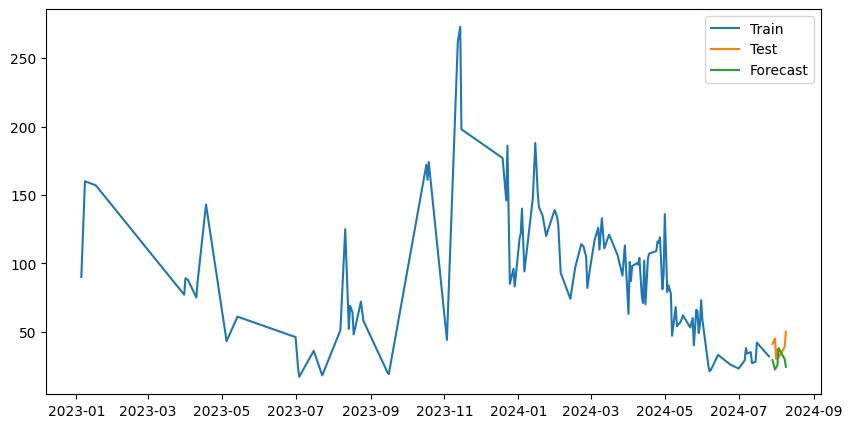

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('AQ-Dataset.csv')

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Optional: Sort by date if not sorted
df = df.sort_index()

# Before splitting
df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')
ts = df['AQI'].dropna()

# Split data into train and test sets (e.g., last 7 days for testing)
train = ts.iloc[:-7]
test = ts.iloc[-7:]

#Debug
print(train.dtype)
print(train.head())

# Define SARIMAX model
# Example order (p,d,q) = (1,1,1), seasonal_order (P,D,Q,s) = (1,1,1,7) for weekly seasonality
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))

# Fit model
model_fit = model.fit(disp=False)

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse:.2f}')

# Plot results
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

**GRAPHICAL NEURAL NETWORK**

In [ ]:
from torch_geometric.utils import to_networkx

# Convert PyG data object to NetworkX graph
G = to_networkx(data, to_undirected=True)

🚀 Starting GNN Analysis for Air Quality Prediction

📊 Loading and preprocessing data...
Dataset shape: (133, 31)
Columns: ['Unnamed: 0', 'Date', 'PM10', 'PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'NH3', 'Benzene', 'Temp', 'RH', 'WS', 'WD', 'BP', 'AQI', 'Area Name', 'Road/Intersection Name', 'Traffic Volume', 'Average Speed', 'Travel Time Index', 'Congestion Level', 'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Weather Conditions', 'Roadwork and Construction Activity']
✅ Data loaded: 133 nodes, 15 features, 665 edges

🎨 Visualizing GNN Architecture...


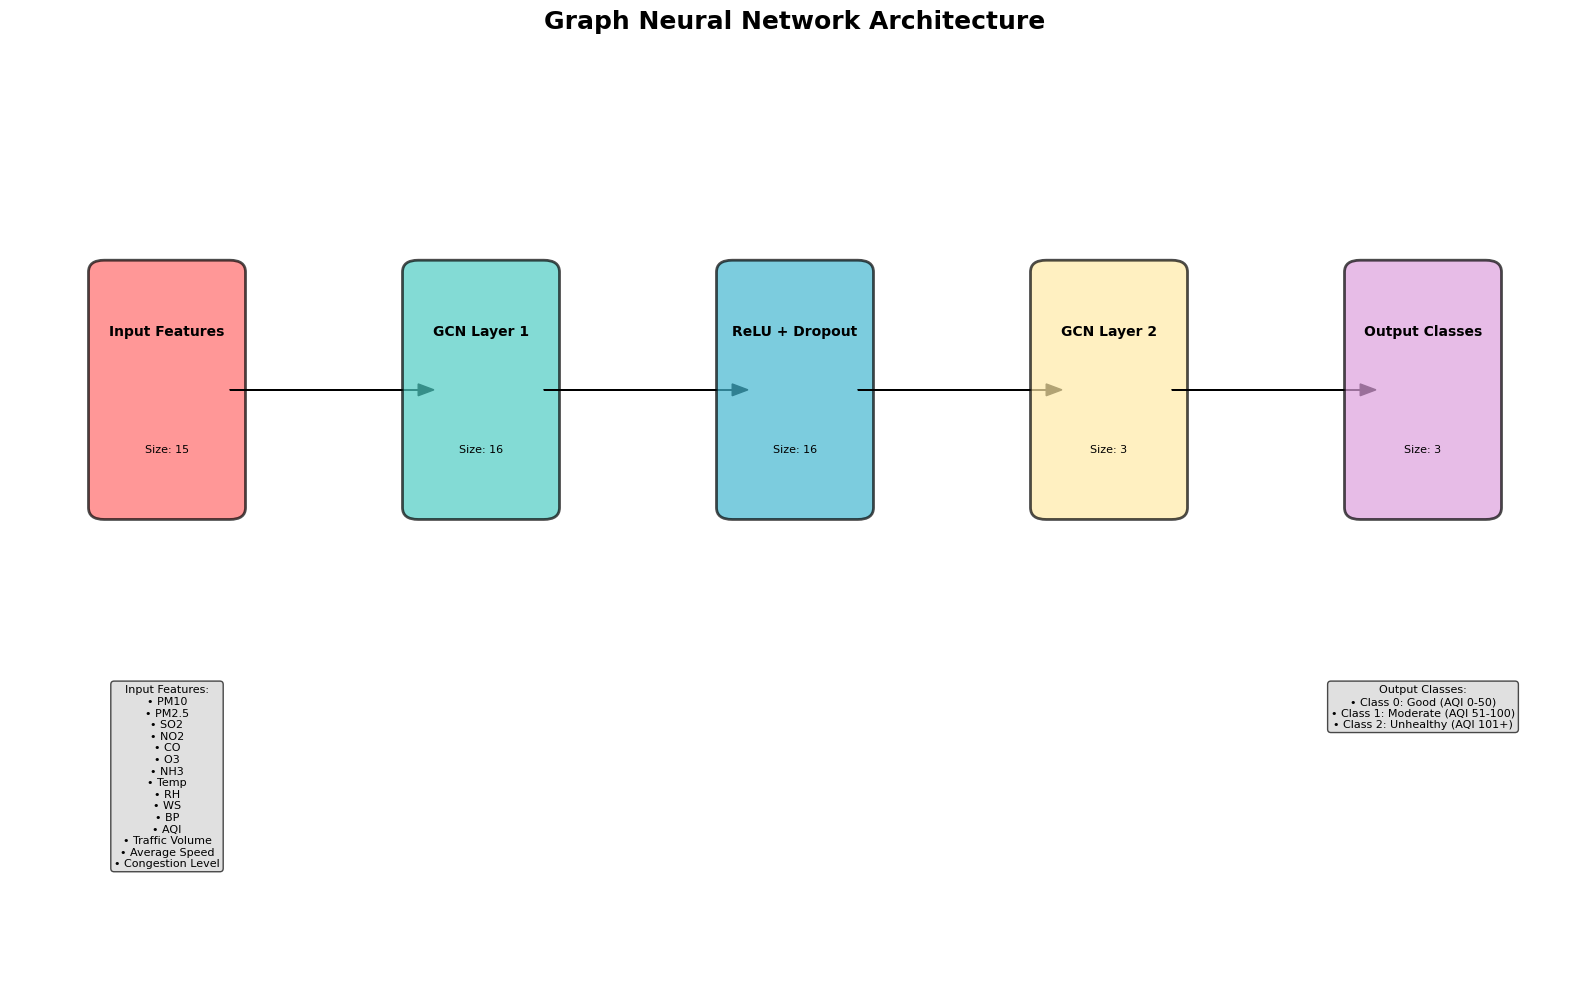


📈 Visualizing Graph Structure...


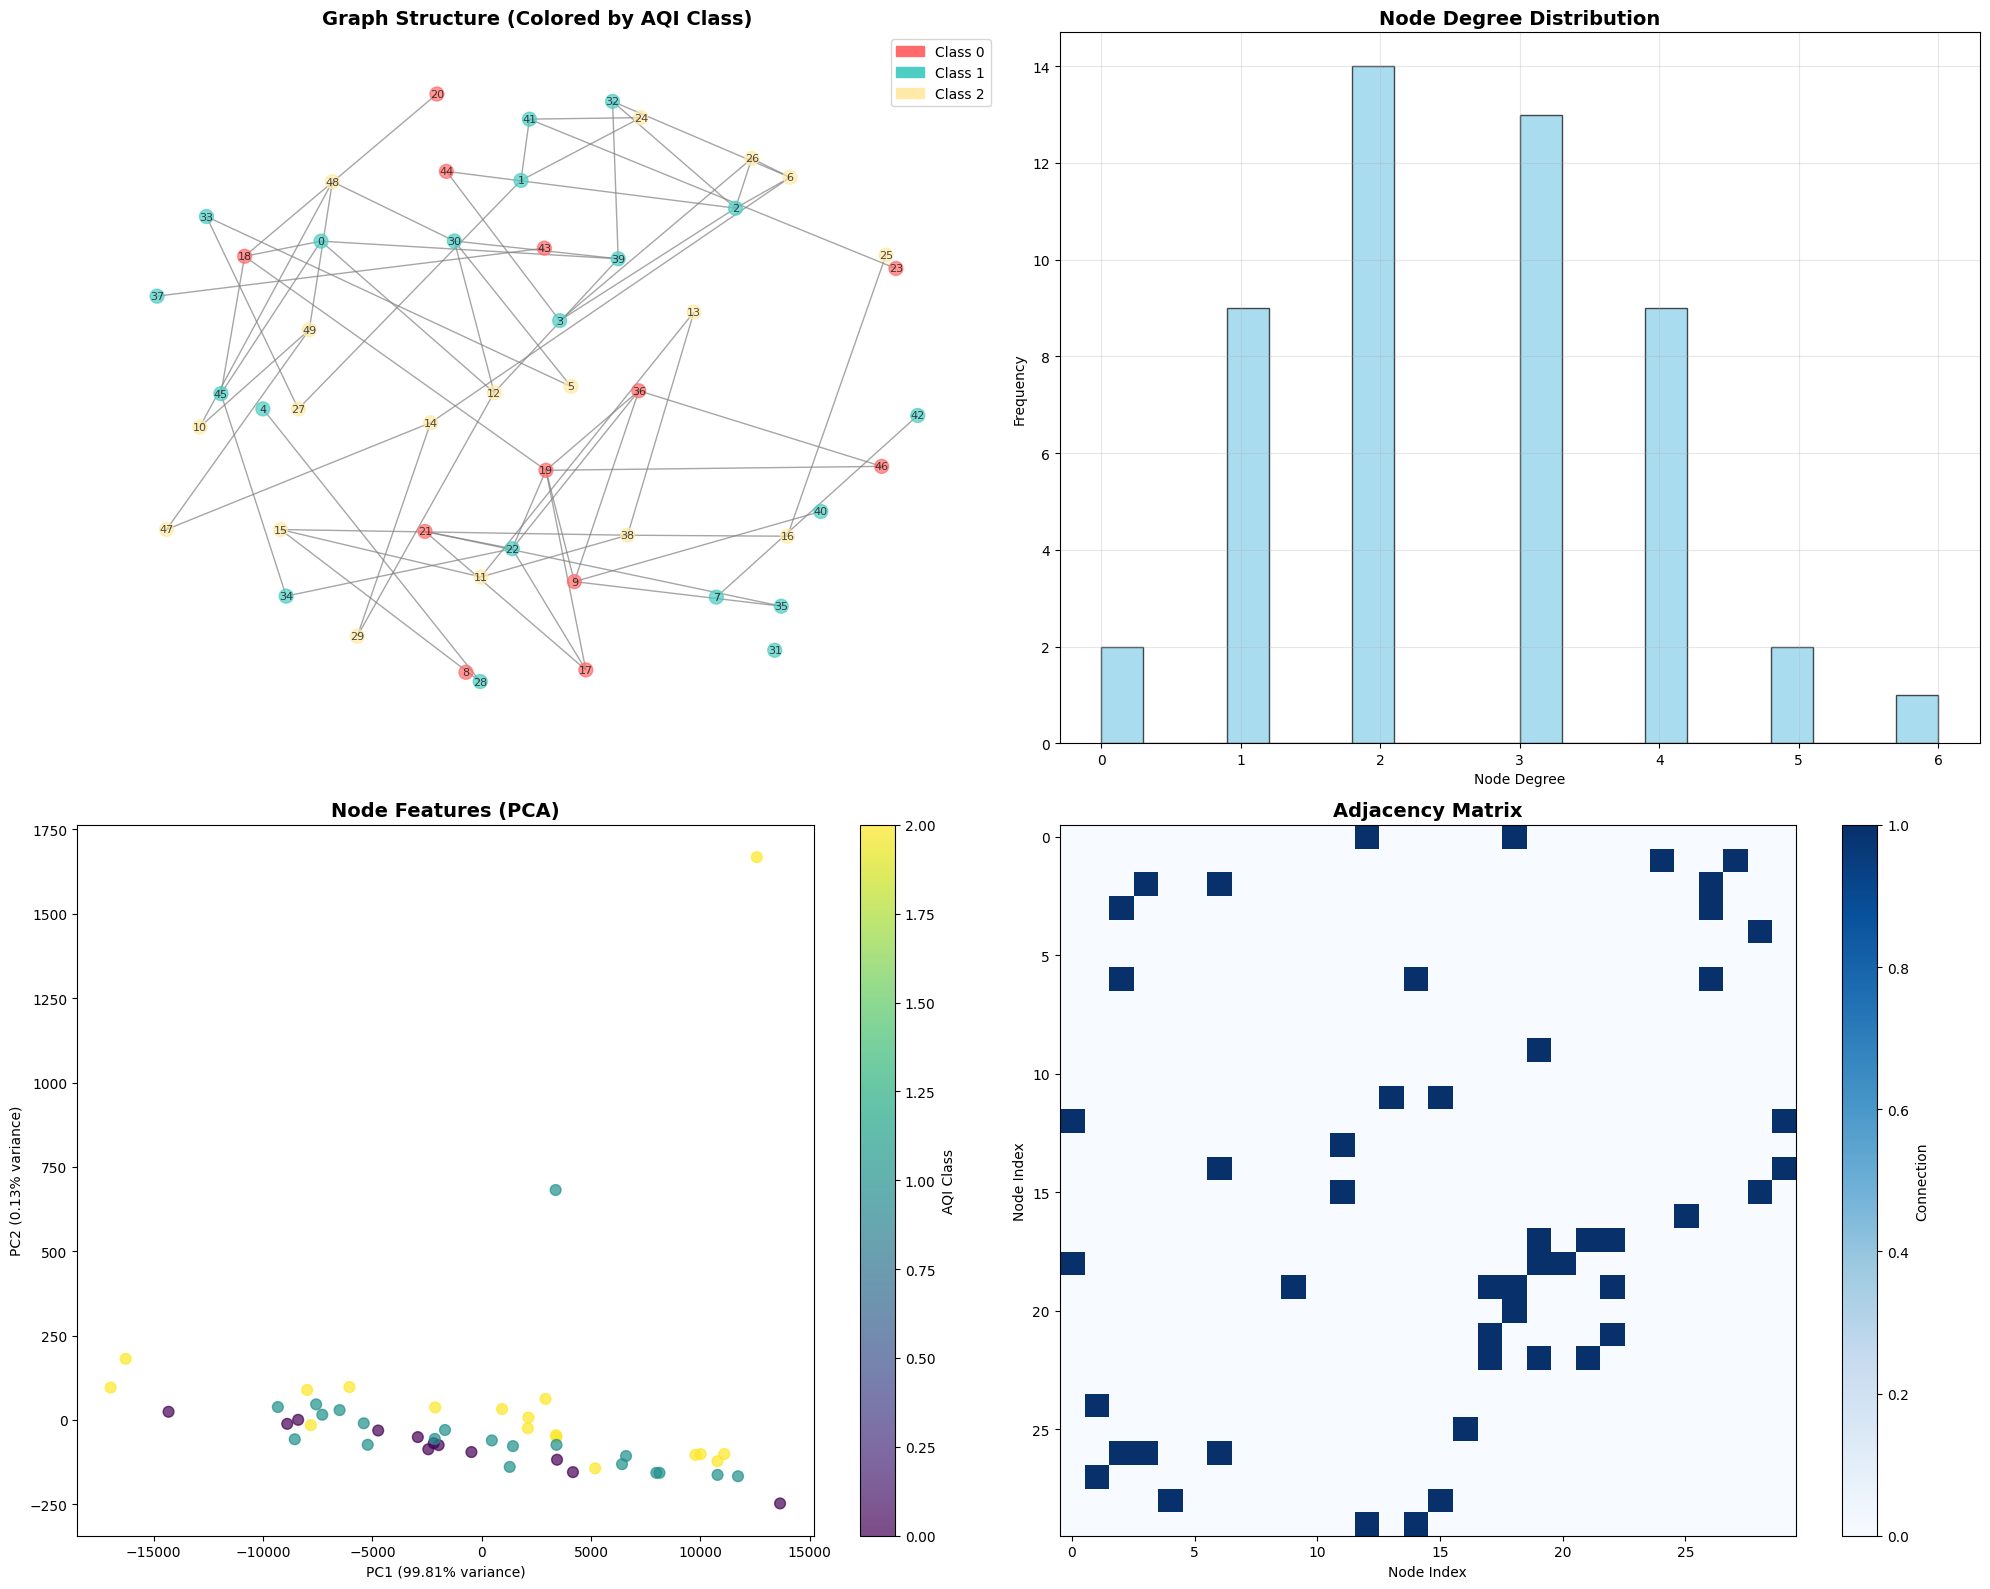


📊 Graph Statistics:
Nodes: 50, Edges: 64
Average degree: 2.56
Density: 0.0522
Connected components: 6

🤖 Training GNN Model...
Epoch   0 | Loss: 6127.9067 | Acc: 0.3609
Epoch  20 | Loss: 1172.6323 | Acc: 0.4737
Epoch  40 | Loss: 848.7818 | Acc: 0.4286
Epoch  60 | Loss: 603.2494 | Acc: 0.3383
Epoch  80 | Loss: 416.5123 | Acc: 0.3684
Epoch 100 | Loss: 308.8420 | Acc: 0.2932
Epoch 120 | Loss: 186.9919 | Acc: 0.4586
Epoch 140 | Loss: 79.4229 | Acc: 0.5263
Epoch 160 | Loss: 35.2085 | Acc: 0.6090
Epoch 180 | Loss: 43.5841 | Acc: 0.5714

📊 Visualizing Training Progress...


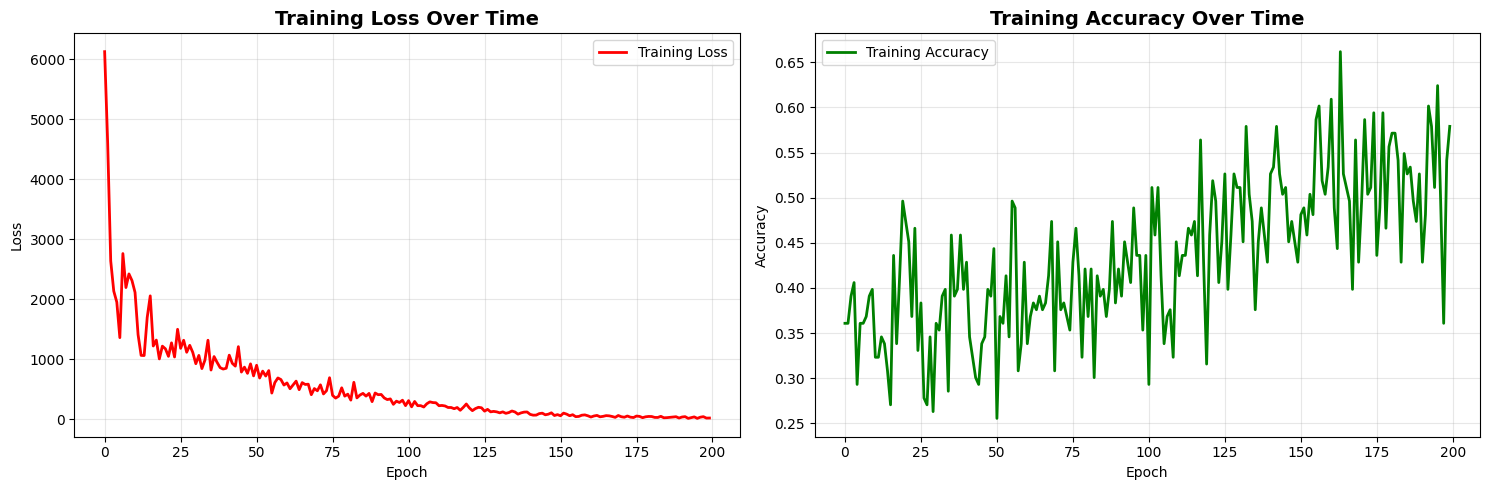


🔍 Visualizing Node Embeddings...


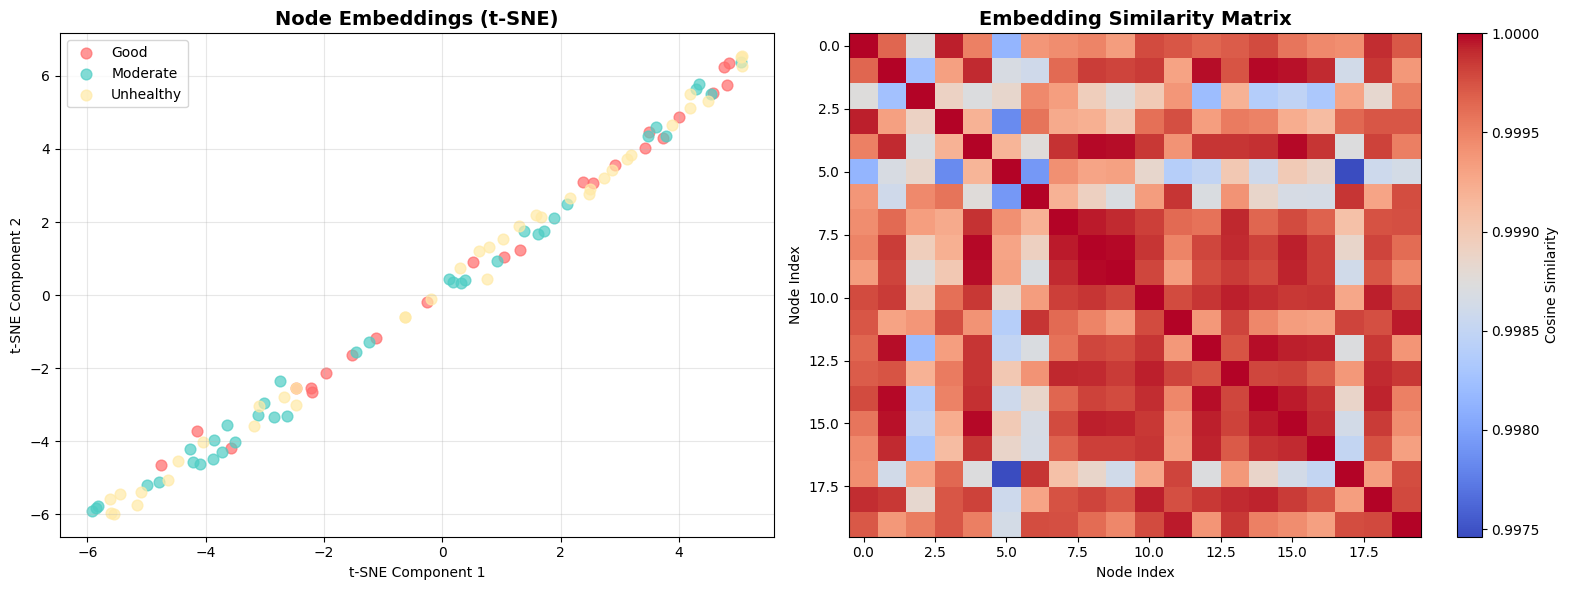


🎯 Visualizing Model Predictions...


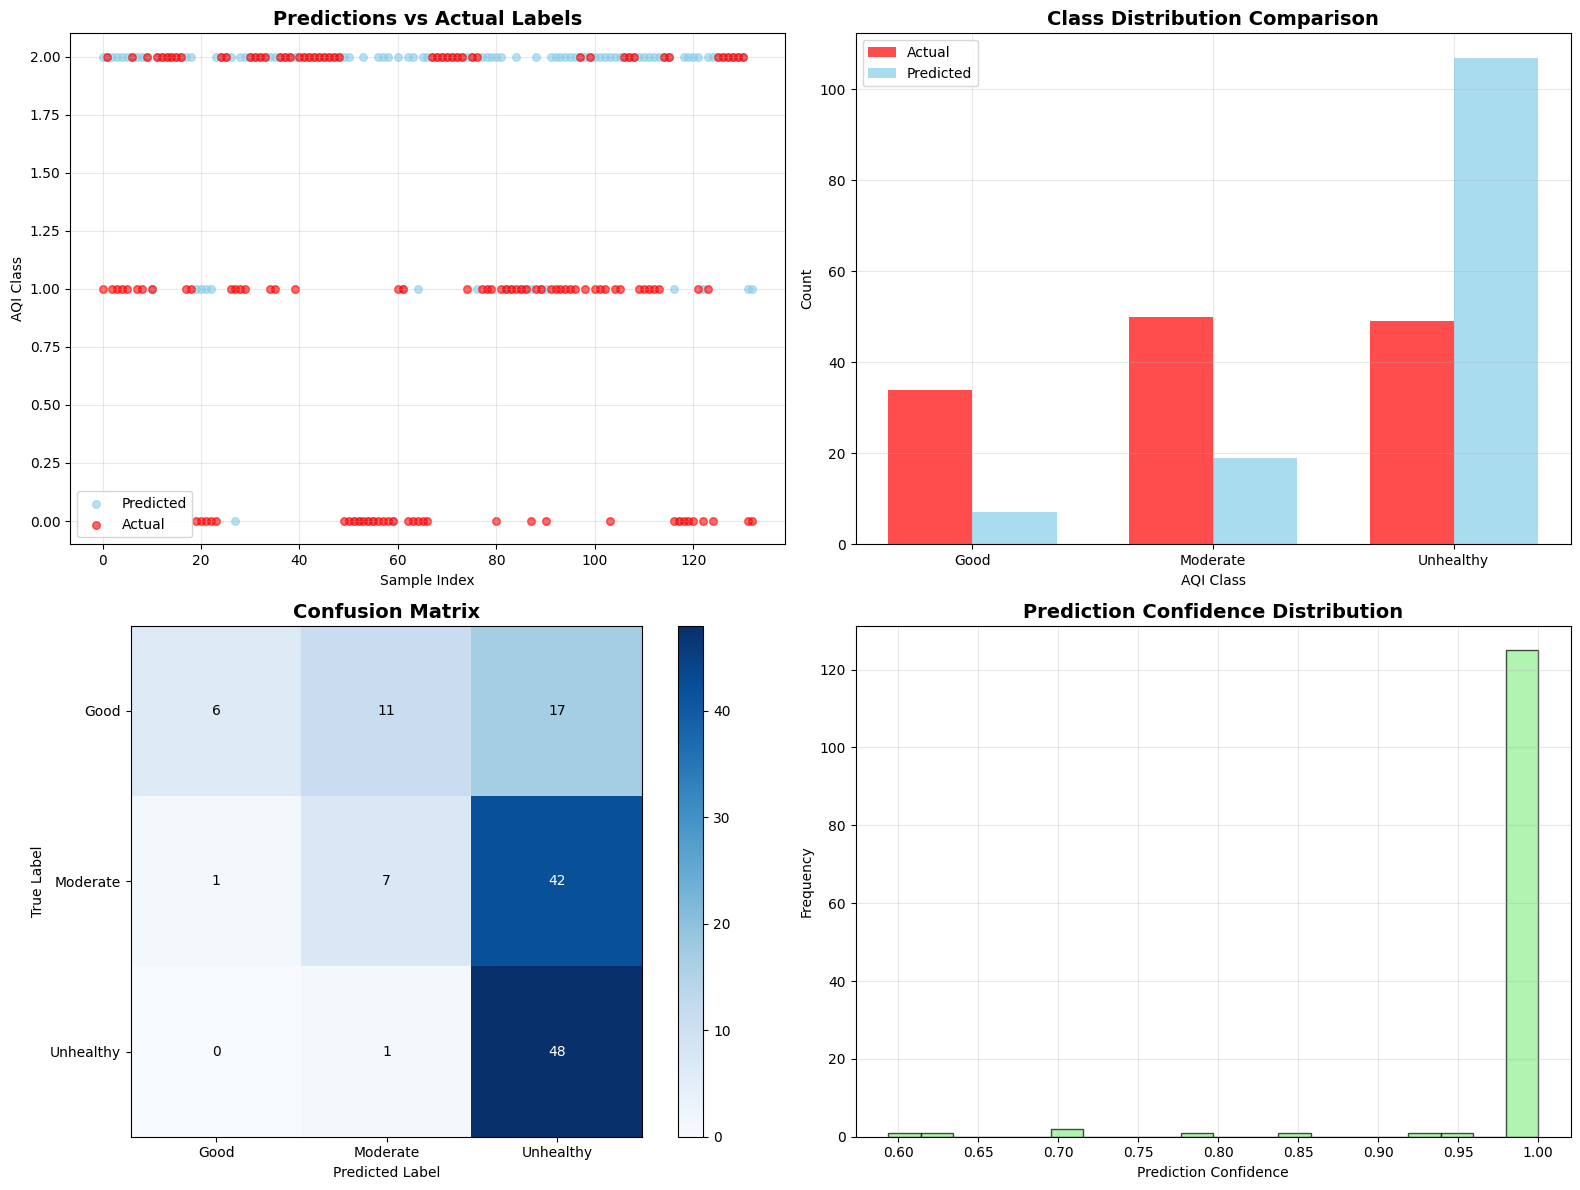


📈 Model Performance Metrics:
Overall Accuracy: 0.4586

Detailed Classification Report:
              precision    recall  f1-score   support

        Good       0.86      0.18      0.29        34
    Moderate       0.37      0.14      0.20        50
   Unhealthy       0.45      0.98      0.62        49

    accuracy                           0.46       133
   macro avg       0.56      0.43      0.37       133
weighted avg       0.52      0.46      0.38       133


🎉 GNN Analysis Complete!

FINAL RESULTS
Final Training Loss: 18.5210
Final Training Accuracy: 0.5789
Number of nodes: 133
Number of edges: 665
Number of features: 15

Calculating Mean Squared Error (MSE)...
 Mean Squared Error (MSE): 0.9248


In [22]:
# Complete GNN Implementation with Comprehensive Visualization
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

# -------------------------
# Data Loading and Preprocessing
# -------------------------
def load_and_preprocess_data(csv_path):
    """Load and preprocess the air quality dataset"""
    df = pd.read_csv(csv_path)

    print("Dataset shape:", df.shape)
    print("Columns:", df.columns.tolist())

    features_cols = ['PM10', 'PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'NH3', 'Temp', 'RH', 'WS', 'BP', 'AQI', 'Traffic Volume', 'Average Speed', 'Congestion Level']
    existing_cols = [col for col in features_cols if col in df.columns]

    # Handle missing values and convert to numeric
    df_clean = df[existing_cols].copy()
    for col in existing_cols:
        if df_clean[col].dtype in ['object', 'category']:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 0)
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Convert to numeric
    for col in existing_cols:
        if df_clean[col].dtype == 'object':
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            if df_clean[col].dtype == 'object':
                df_clean[col] = df_clean[col].astype('category').cat.codes

    features = df_clean.fillna(0).values.astype(float)
    x = torch.tensor(features, dtype=torch.float)

    # Create labels
    if 'AQI' in df.columns:


        #aqi = df['AQI'].fillna(df['AQI'].median()).astype(float)
      aqi = pd.to_numeric(df['AQI'], errors='coerce')
      aqi = aqi.fillna(aqi.median())

    # Create meaningful AQI classes based on standard ranges
    # Good (0-50), Moderate (51-100), Unhealthy (101+)
      labels = pd.cut(aqi, bins=[0, 50, 100, np.inf], labels=[0, 1, 2], include_lowest=True)
      labels = labels.cat.codes
      labels = np.where(labels == -1, 0, labels)
      y = torch.tensor(labels, dtype=torch.long)

    else:
      y = torch.randint(0, 3, (x.shape[0],))

    return x, y, existing_cols

def create_graph_structure(x, k=5):
    """Create graph structure using k-nearest neighbors"""
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x.numpy())

    k = min(k, x.shape[0] - 1)
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(x_scaled)
    distances, indices = nbrs.kneighbors(x_scaled)

    source_nodes = []
    target_nodes = []
    for i in range(x.shape[0]):
        for j in range(1, k+1):
            if indices[i, j] < x.shape[0]:
                source_nodes.append(i)
                target_nodes.append(indices[i, j])

    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    return edge_index

# -------------------------
# GNN Model
# -------------------------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# -------------------------
# Visualization Functions
# -------------------------
def visualize_gnn_architecture(feature_names):
    """Visualize the GNN architecture"""
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    layers = [
        {"name": "Input Features", "size": len(feature_names), "color": "#FF6B6B", "pos": (1, 5)},
        {"name": "GCN Layer 1", "size": 16, "color": "#4ECDC4", "pos": (3, 5)},
        {"name": "ReLU + Dropout", "size": 16, "color": "#45B7D1", "pos": (5, 5)},
        {"name": "GCN Layer 2", "size": 3, "color": "#FFEAA7", "pos": (7, 5)},
        {"name": "Output Classes", "size": 3, "color": "#DDA0DD", "pos": (9, 5)}
    ]

    # Draw layers
    for i, layer in enumerate(layers):
        box = FancyBboxPatch(
            (layer["pos"][0]-0.4, layer["pos"][1]-1), 0.8, 2,
            boxstyle="round,pad=0.1",
            facecolor=layer["color"],
            edgecolor='black',
            linewidth=2,
            alpha=0.7
        )
        ax.add_patch(box)

        ax.text(layer["pos"][0], layer["pos"][1]+0.5, layer["name"],
                ha='center', va='center', fontsize=10, fontweight='bold')
        ax.text(layer["pos"][0], layer["pos"][1]-0.5, f"Size: {layer['size']}",
                ha='center', va='center', fontsize=8)

        if i < len(layers) - 1:
            ax.arrow(layer["pos"][0]+0.4, layer["pos"][1],
                    layers[i+1]["pos"][0] - layer["pos"][0] - 0.8, 0,
                    head_width=0.1, head_length=0.1, fc='black', ec='black')

    # Add feature list
    feature_text = "Input Features:\n" + "\n".join([f"• {name}" for name in feature_names])
    ax.text(1, 2.5, feature_text, ha='center', va='top', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.7))

    # Add output classes
    output_text = """Output Classes:
• Class 0: Good (AQI 0-50)
• Class 1: Moderate (AQI 51-100)
• Class 2: Unhealthy (AQI 101+)"""
    ax.text(9, 2.5, output_text, ha='center', va='top', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.7))

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    plt.title("Graph Neural Network Architecture", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_graph_structure(data, max_nodes=50):
    """Visualize the graph structure"""
    # Sample nodes if too many
    if data.x.shape[0] > max_nodes:
        indices = np.random.choice(data.x.shape[0], max_nodes, replace=False)
        indices = np.sort(indices)

        node_mask = torch.zeros(data.x.shape[0], dtype=torch.bool)
        node_mask[indices] = True

        edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
        sub_edge_index = data.edge_index[:, edge_mask]

        old_to_new = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(indices)}
        sub_edge_index = torch.tensor([[old_to_new[idx.item()] for idx in sub_edge_index[0]],
                                       [old_to_new[idx.item()] for idx in sub_edge_index[1]]])

        sub_data = Data(x=data.x[indices], edge_index=sub_edge_index, y=data.y[indices])
    else:
        sub_data = data

    # Convert to NetworkX
    G = to_networkx(sub_data, to_undirected=True)

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Graph visualization
    ax1 = axes[0, 0]
    pos = nx.spring_layout(G, k=1, iterations=50)
    colors = ['#FF6B6B', '#4ECDC4', '#FFEAA7']
    node_colors = [colors[label] for label in sub_data.y.numpy()]

    nx.draw(G, pos, ax=ax1, node_color=node_colors, node_size=100,
            with_labels=True, font_size=8, edge_color='gray', alpha=0.7)
    ax1.set_title("Graph Structure (Colored by AQI Class)", fontsize=14, fontweight='bold')

    legend_elements = [mpatches.Patch(color=colors[i], label=f'Class {i}') for i in range(3)]
    ax1.legend(handles=legend_elements, loc='upper right')

    # Degree distribution
    ax2 = axes[0, 1]
    degrees = [G.degree(n) for n in G.nodes()]
    ax2.hist(degrees, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Node Degree')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Node Degree Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # PCA of features
    ax3 = axes[1, 0]
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(sub_data.x.numpy())

    scatter = ax3.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=sub_data.y.numpy(), cmap='viridis', alpha=0.7, s=60)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax3.set_title('Node Features (PCA)', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax3, label='AQI Class')

    # Adjacency matrix
    ax4 = axes[1, 1]
    adj_matrix = nx.adjacency_matrix(G).toarray()

    if adj_matrix.shape[0] > 30:
        adj_matrix = adj_matrix[:30, :30]

    im = ax4.imshow(adj_matrix, cmap='Blues', aspect='auto')
    ax4.set_xlabel('Node Index')
    ax4.set_ylabel('Node Index')
    ax4.set_title('Adjacency Matrix', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax4, label='Connection')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 Graph Statistics:")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Density: {nx.density(G):.4f}")
    print(f"Connected components: {nx.number_connected_components(G)}")

def visualize_node_embeddings(model, data, max_nodes=100):
    """Visualize learned node embeddings"""
    model.eval()
    with torch.no_grad():
        x = model.conv1(data.x, data.edge_index).relu()

        if data.x.shape[0] > max_nodes:
            indices = np.random.choice(data.x.shape[0], max_nodes, replace=False)
            x = x[indices]
            labels = data.y[indices]
        else:
            labels = data.y

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(x)-1))
    embeddings_2d = tsne.fit_transform(x.numpy())

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # t-SNE plot
    ax1 = axes[0]
    colors = ['#FF6B6B', '#4ECDC4', '#FFEAA7']
    class_names = ['Good', 'Moderate', 'Unhealthy']

    for i, (color, name) in enumerate(zip(colors, class_names)):
        mask = labels.numpy() == i
        ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=color, label=name, alpha=0.7, s=60)

    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.set_title('Node Embeddings (t-SNE)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Similarity matrix
    ax2 = axes[1]
    n_show = min(20, len(x))
    subset_embeddings = x[:n_show]
    similarity_matrix = cosine_similarity(subset_embeddings.numpy())

    im = ax2.imshow(similarity_matrix, cmap='coolwarm', aspect='auto')
    ax2.set_xlabel('Node Index')
    ax2.set_ylabel('Node Index')
    ax2.set_title('Embedding Similarity Matrix', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax2, label='Cosine Similarity')

    plt.tight_layout()
    plt.show()

def visualize_training_progress(train_losses, train_accs, val_losses=None, val_accs=None):
    """Visualize training progress"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1 = axes[0]
    ax1.plot(train_losses, label='Training Loss', color='red', linewidth=2)
    if val_losses:
        ax1.plot(val_losses, label='Validation Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2 = axes[1]
    ax2.plot(train_accs, label='Training Accuracy', color='green', linewidth=2)
    if val_accs:
        ax2.plot(val_accs, label='Validation Accuracy', color='orange', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, data):
    """Visualize model predictions vs actual labels"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1).numpy()
        actual = data.y.numpy()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Predictions vs Actual scatter
    ax1 = axes[0, 0]
    ax1.scatter(range(len(pred)), pred, alpha=0.6, color='skyblue', label='Predicted', s=30)
    ax1.scatter(range(len(actual)), actual, alpha=0.6, color='red', label='Actual', s=30)
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('AQI Class')
    ax1.set_title('Predictions vs Actual Labels', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Class distribution comparison
    ax2 = axes[0, 1]
    class_names = ['Good', 'Moderate', 'Unhealthy']
    pred_counts = np.bincount(pred, minlength=3)
    actual_counts = np.bincount(actual, minlength=3)

    x_pos = np.arange(len(class_names))
    width = 0.35

    ax2.bar(x_pos - width/2, actual_counts, width, label='Actual', color='red', alpha=0.7)
    ax2.bar(x_pos + width/2, pred_counts, width, label='Predicted', color='skyblue', alpha=0.7)
    ax2.set_xlabel('AQI Class')
    ax2.set_ylabel('Count')
    ax2.set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(class_names)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Confusion Matrix
    ax3 = axes[1, 0]
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, pred)
    im = ax3.imshow(cm, interpolation='nearest', cmap='Blues')
    ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax3.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')
    ax3.set_xticks(range(3))
    ax3.set_yticks(range(3))
    ax3.set_xticklabels(class_names)
    ax3.set_yticklabels(class_names)
    plt.colorbar(im, ax=ax3)

    # Prediction confidence
    ax4 = axes[1, 1]
    probs = torch.softmax(out, dim=1)
    max_probs = probs.max(dim=1)[0].numpy()

    ax4.hist(max_probs, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.set_xlabel('Prediction Confidence')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    from sklearn.metrics import classification_report, accuracy_score
    print("\n📈 Model Performance Metrics:")
    print(f"Overall Accuracy: {accuracy_score(actual, pred):.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(actual, pred, target_names=class_names))

# -------------------------
# Main Execution Function
# -------------------------
def main_gnn_analysis(csv_path="AQ-Dataset.csv"):
    """Complete GNN analysis with all visualizations"""
    print("🚀 Starting GNN Analysis for Air Quality Prediction")
    print("=" * 60)

    # 1. Load and preprocess data
    print("\n📊 Loading and preprocessing data...")
    x, y, feature_names = load_and_preprocess_data(csv_path)
    edge_index = create_graph_structure(x)
    data = Data(x=x, edge_index=edge_index, y=y)

    print(f"✅ Data loaded: {x.shape[0]} nodes, {x.shape[1]} features, {edge_index.shape[1]} edges")

    # 2. Visualize GNN architecture
    print("\n🎨 Visualizing GNN Architecture...")
    visualize_gnn_architecture(feature_names)

    # 3. Visualize graph structure
    print("\n📈 Visualizing Graph Structure...")
    visualize_graph_structure(data)

    # 4. Create and train model
    print("\n🤖 Training GNN Model...")
    model = GCN(in_channels=x.shape[1], hidden_channels=16, num_classes=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    train_accs = []

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = (pred == data.y).sum() / data.y.size(0)

        train_losses.append(loss.item())
        train_accs.append(acc.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Acc: {acc:.4f}")

    # 5. Visualize training progress
    print("\n📊 Visualizing Training Progress...")
    visualize_training_progress(train_losses, train_accs)

    # 6. Visualize node embeddings
    print("\n🔍 Visualizing Node Embeddings...")
    visualize_node_embeddings(model, data)

    # 7. Visualize predictions
    print("\n🎯 Visualizing Model Predictions...")
    visualize_predictions(model, data)

    print("\n🎉 GNN Analysis Complete!")
    print("=" * 60)


    # -------------------------
    # Print final statistics
    # -------------------------
    print("\n" + "="*50)
    print("FINAL RESULTS")
    print("="*50)
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {edge_index.shape[1]}")
    print(f"Number of features: {x.shape[1]}")

    # After visualization of predictions
    print("\nCalculating Mean Squared Error (MSE)...")
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred_labels = out.argmax(dim=1).cpu().numpy()
        true_labels = data.y.cpu().numpy()

    mse = mean_squared_error(true_labels, pred_labels)
    print(f'\033[1m Mean Squared Error (MSE): {mse:.4f}\033[0m')


    return model, data, train_losses, train_accs

# -------------------------
# Usage Example
# -------------------------
if __name__ == "__main__":
    # Run complete analysis
    model, data, losses, accs = main_gnn_analysis("AQ-Dataset.csv")


    # You can also run individual visualizations:
    # visualize_gnn_architecture(['PM10', 'PM2.5', 'SO2', 'NO2', 'CO', 'O3'])
    # visualize_graph_structure(data)
    # visualize_node_embeddings(model, data)
    # visualize_predictions(model, data)

🚀 Starting GNN Analysis for Air Quality Prediction

📊 Loading and preprocessing data...
Dataset shape: (133, 31)
Columns: ['Unnamed: 0', 'Date', 'PM10', 'PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'NH3', 'Benzene', 'Temp', 'RH', 'WS', 'WD', 'BP', 'AQI', 'Area Name', 'Road/Intersection Name', 'Traffic Volume', 'Average Speed', 'Travel Time Index', 'Congestion Level', 'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Weather Conditions', 'Roadwork and Construction Activity']
✅ Data loaded: 133 nodes, 15 features, 665 edges

🎨 Visualizing GNN Architecture...


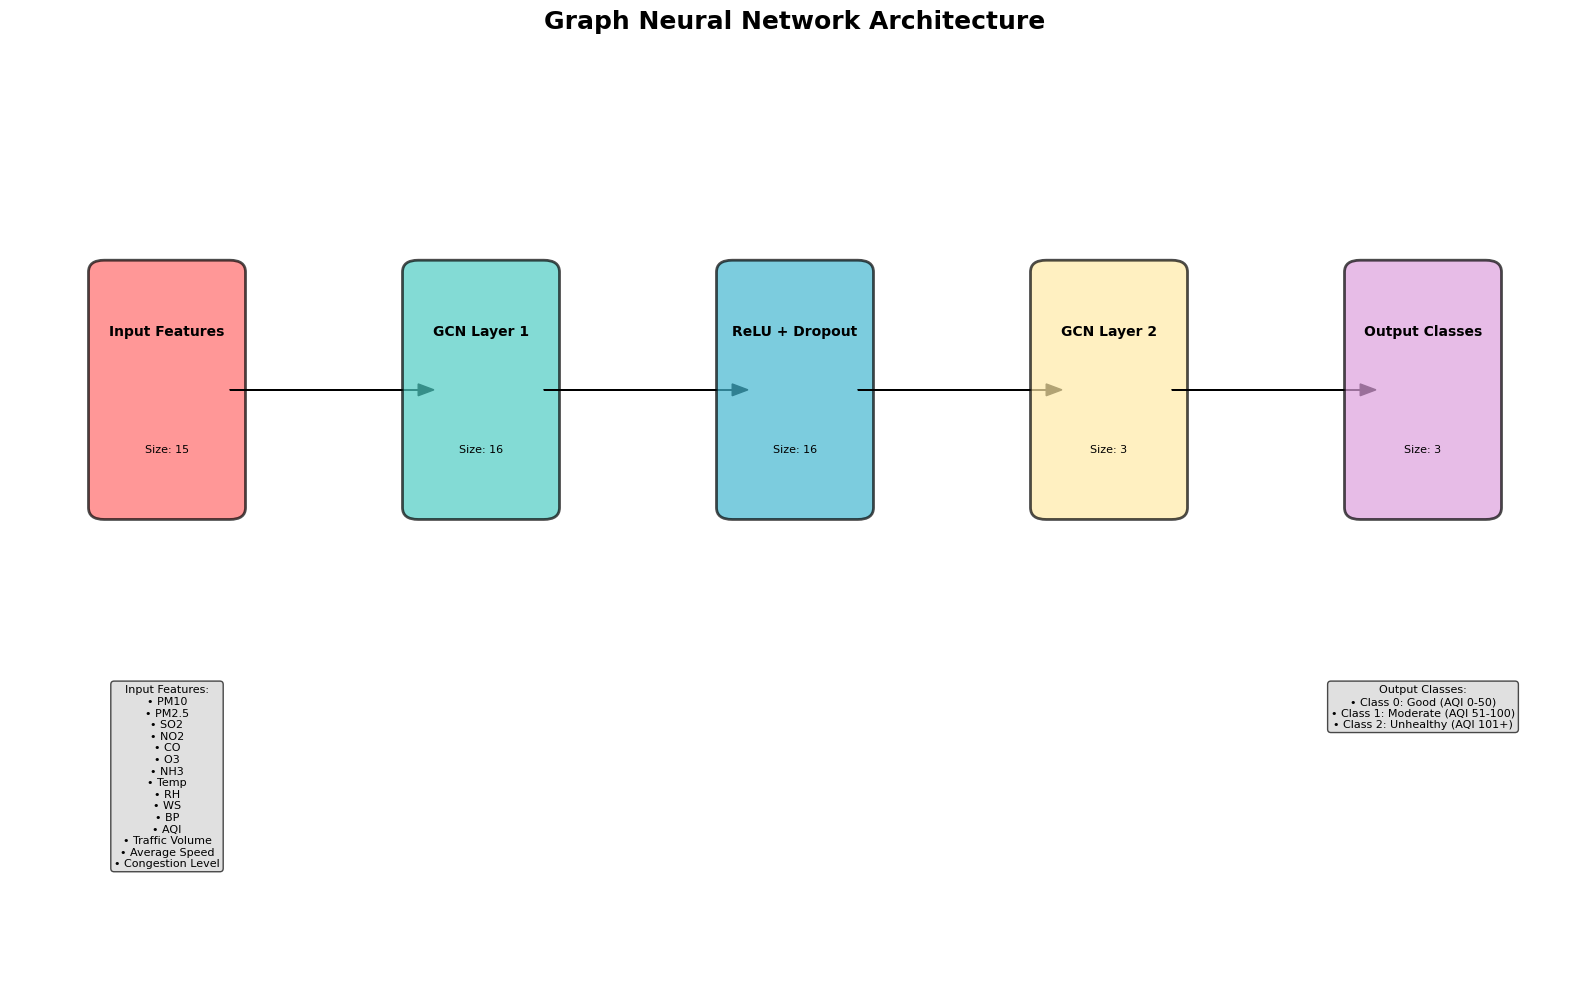


📈 Visualizing Graph Structure...


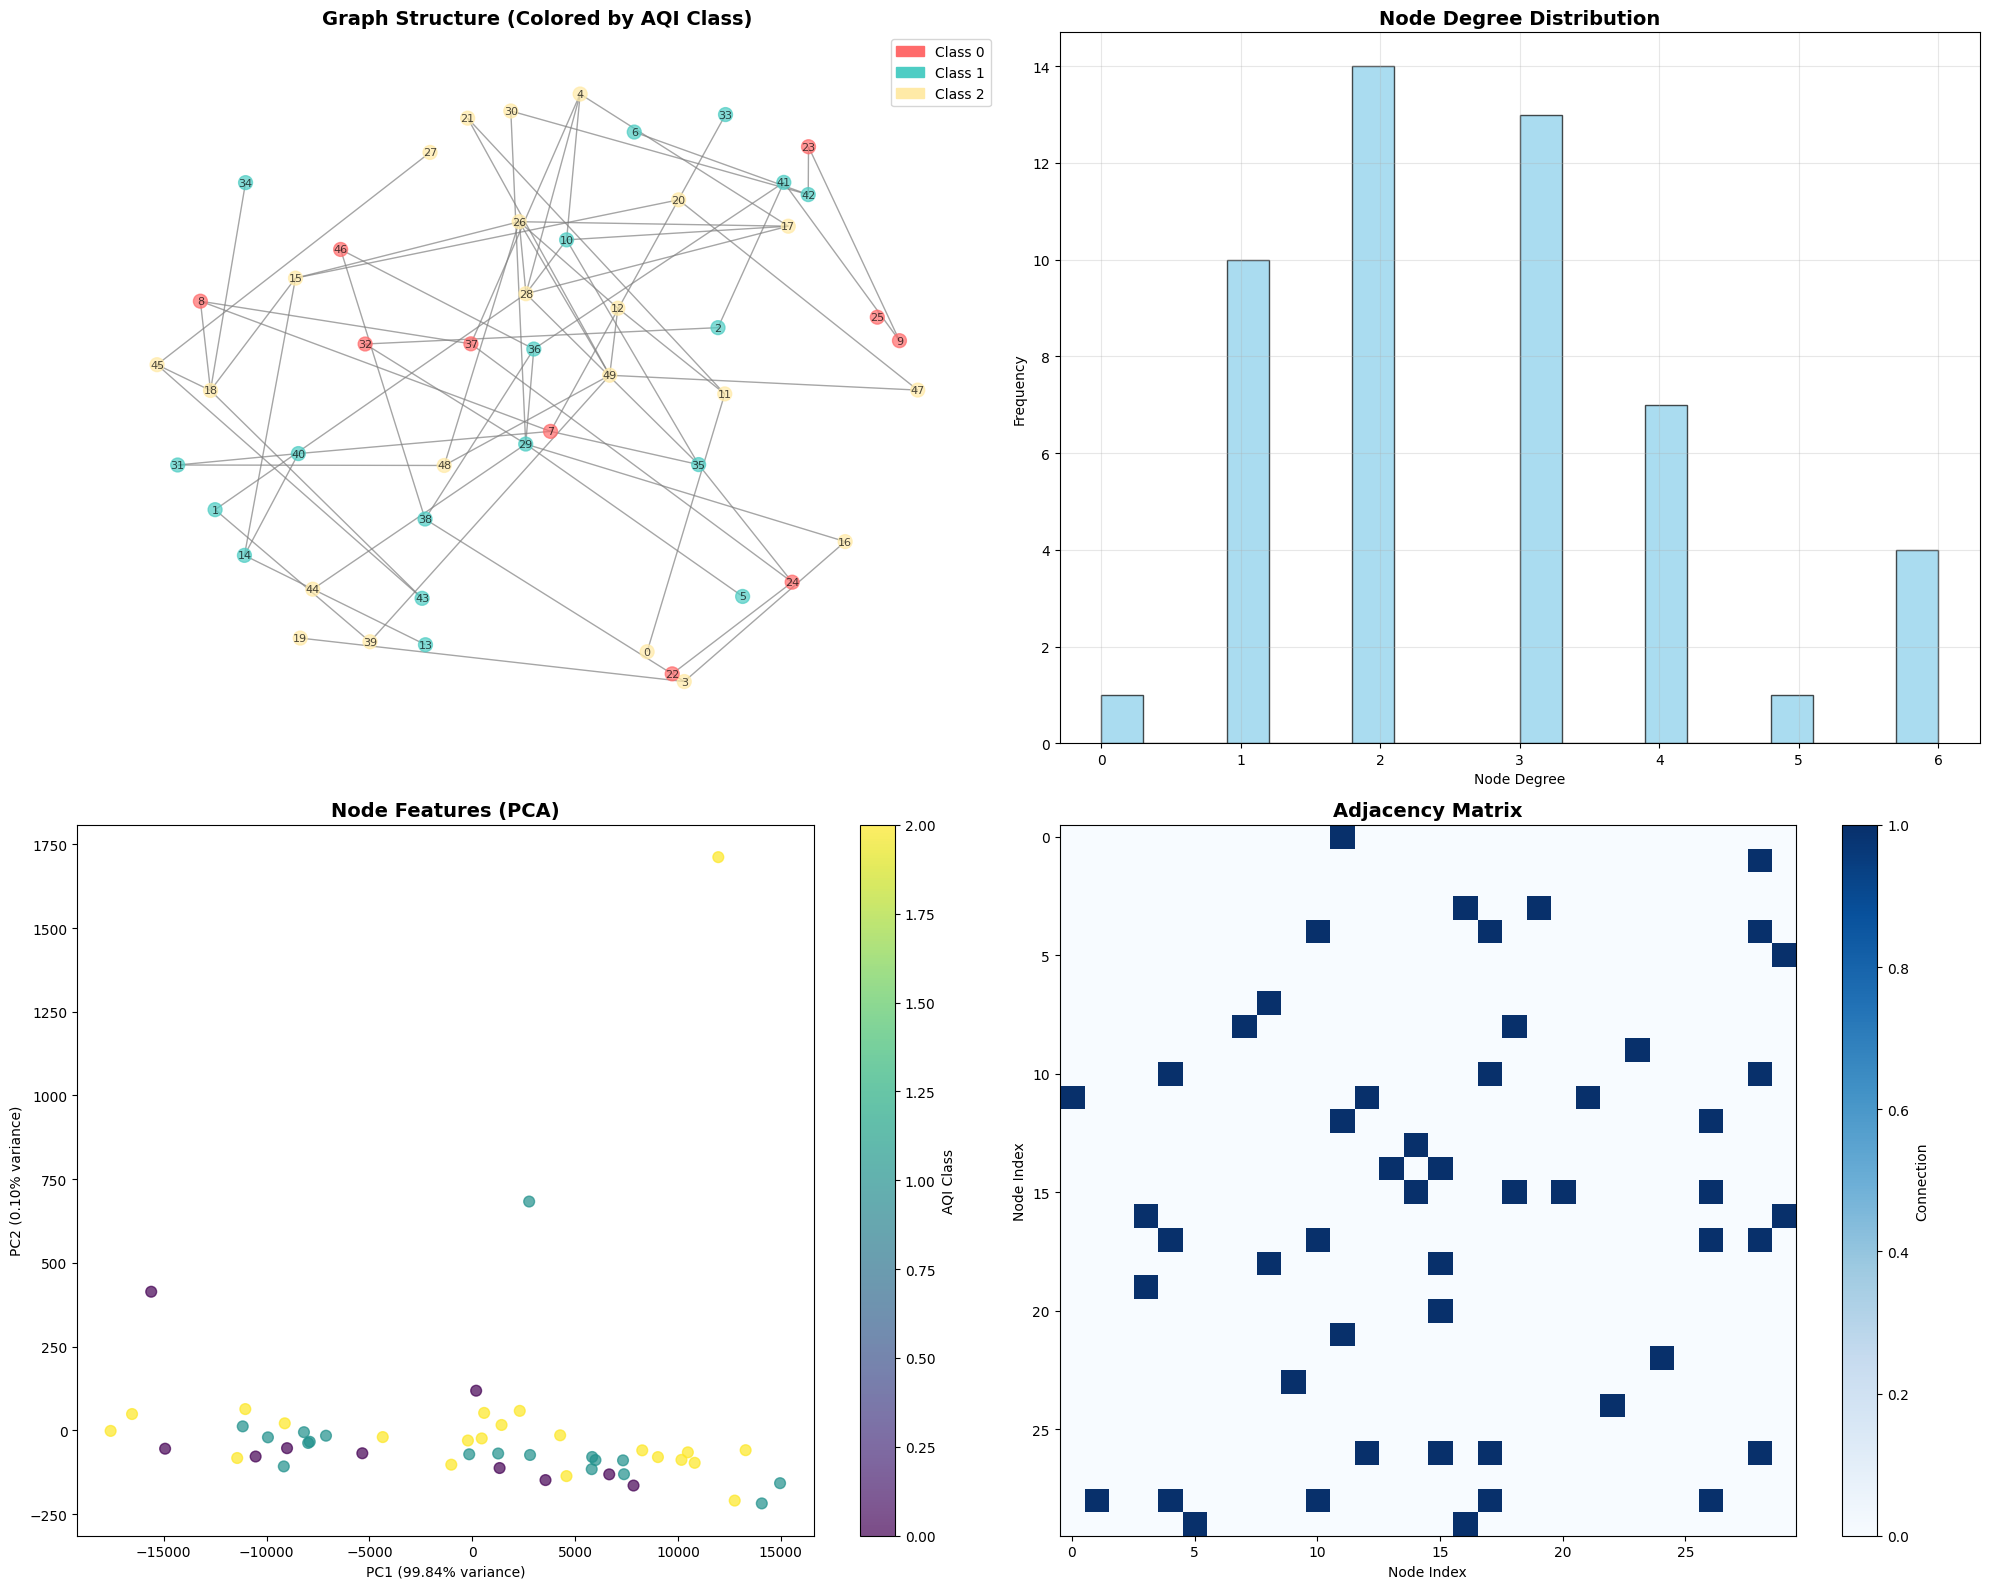


📊 Graph Statistics:
Nodes: 50, Edges: 67
Average degree: 2.68
Density: 0.0547
Connected components: 3

🤖 Training GNN Model...
Epoch   0 | Loss: 9924.3809 | Acc: 0.2406
Epoch  20 | Loss: 1512.2172 | Acc: 0.3308
Epoch  40 | Loss: 1078.6486 | Acc: 0.4060
Epoch  60 | Loss: 1231.7192 | Acc: 0.2932
Epoch  80 | Loss: 579.9996 | Acc: 0.4586
Epoch 100 | Loss: 499.5473 | Acc: 0.2857
Epoch 120 | Loss: 312.9625 | Acc: 0.4662
Epoch 140 | Loss: 213.3572 | Acc: 0.5564
Epoch 160 | Loss: 122.3956 | Acc: 0.5639
Epoch 180 | Loss: 53.5626 | Acc: 0.6165

📊 Visualizing Training Progress...


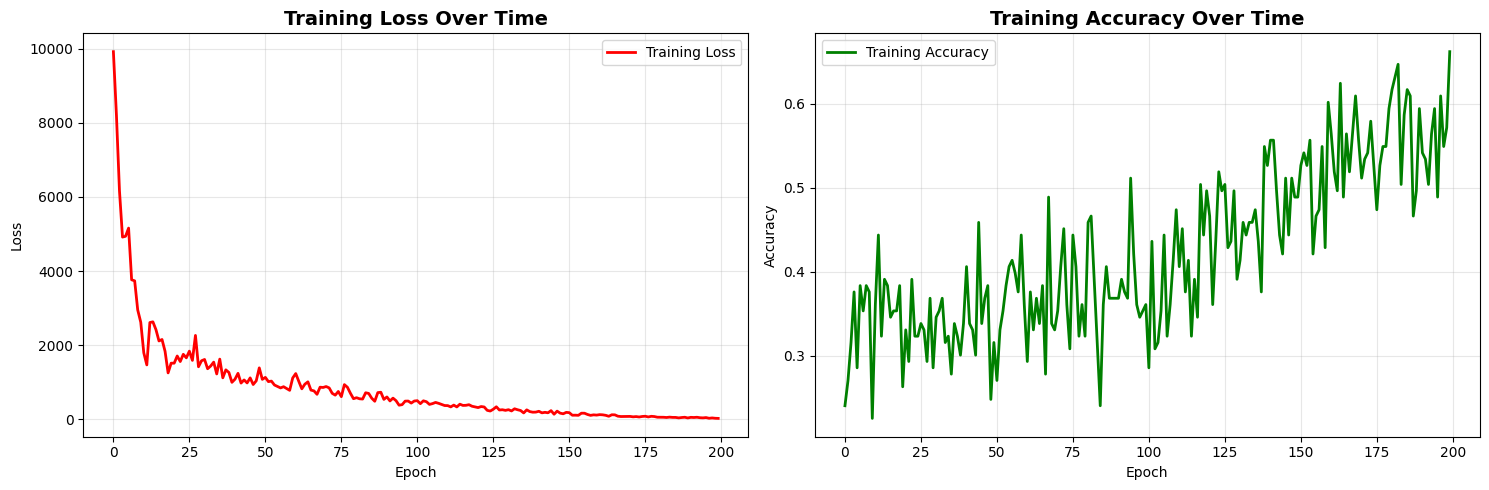


🔍 Visualizing Node Embeddings...


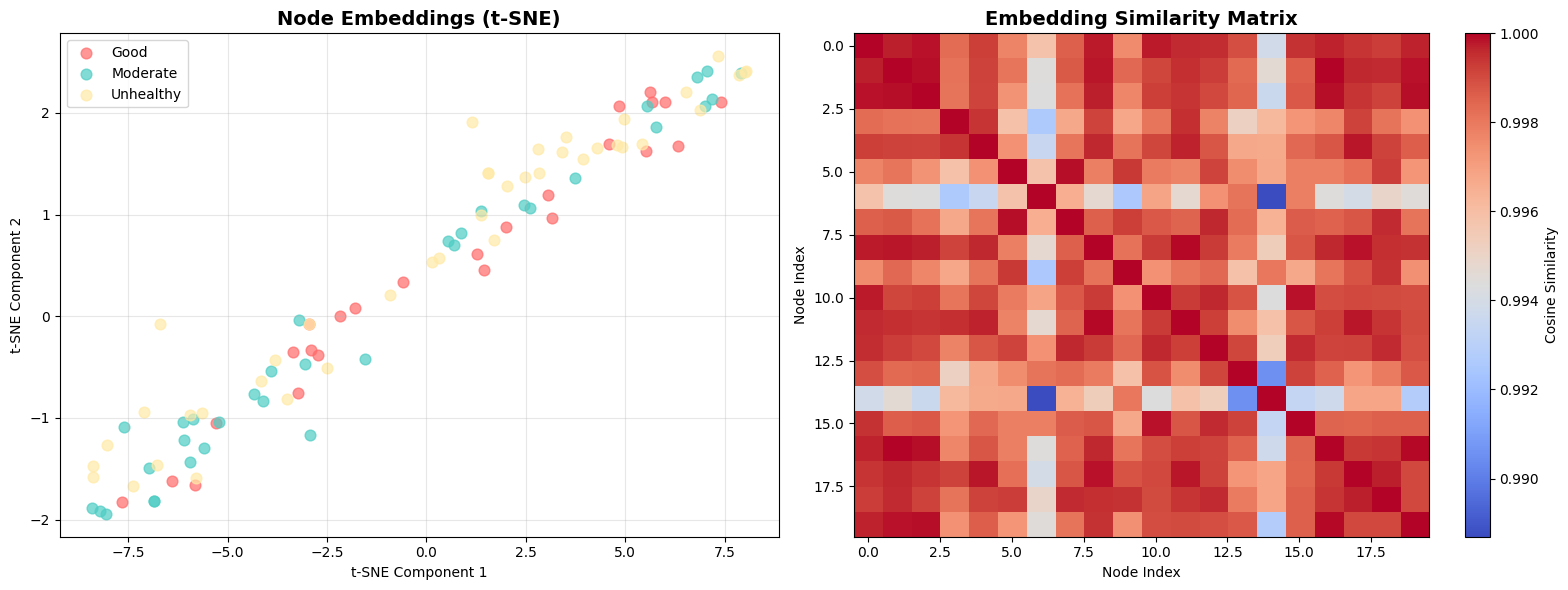


🎯 Visualizing Model Predictions...


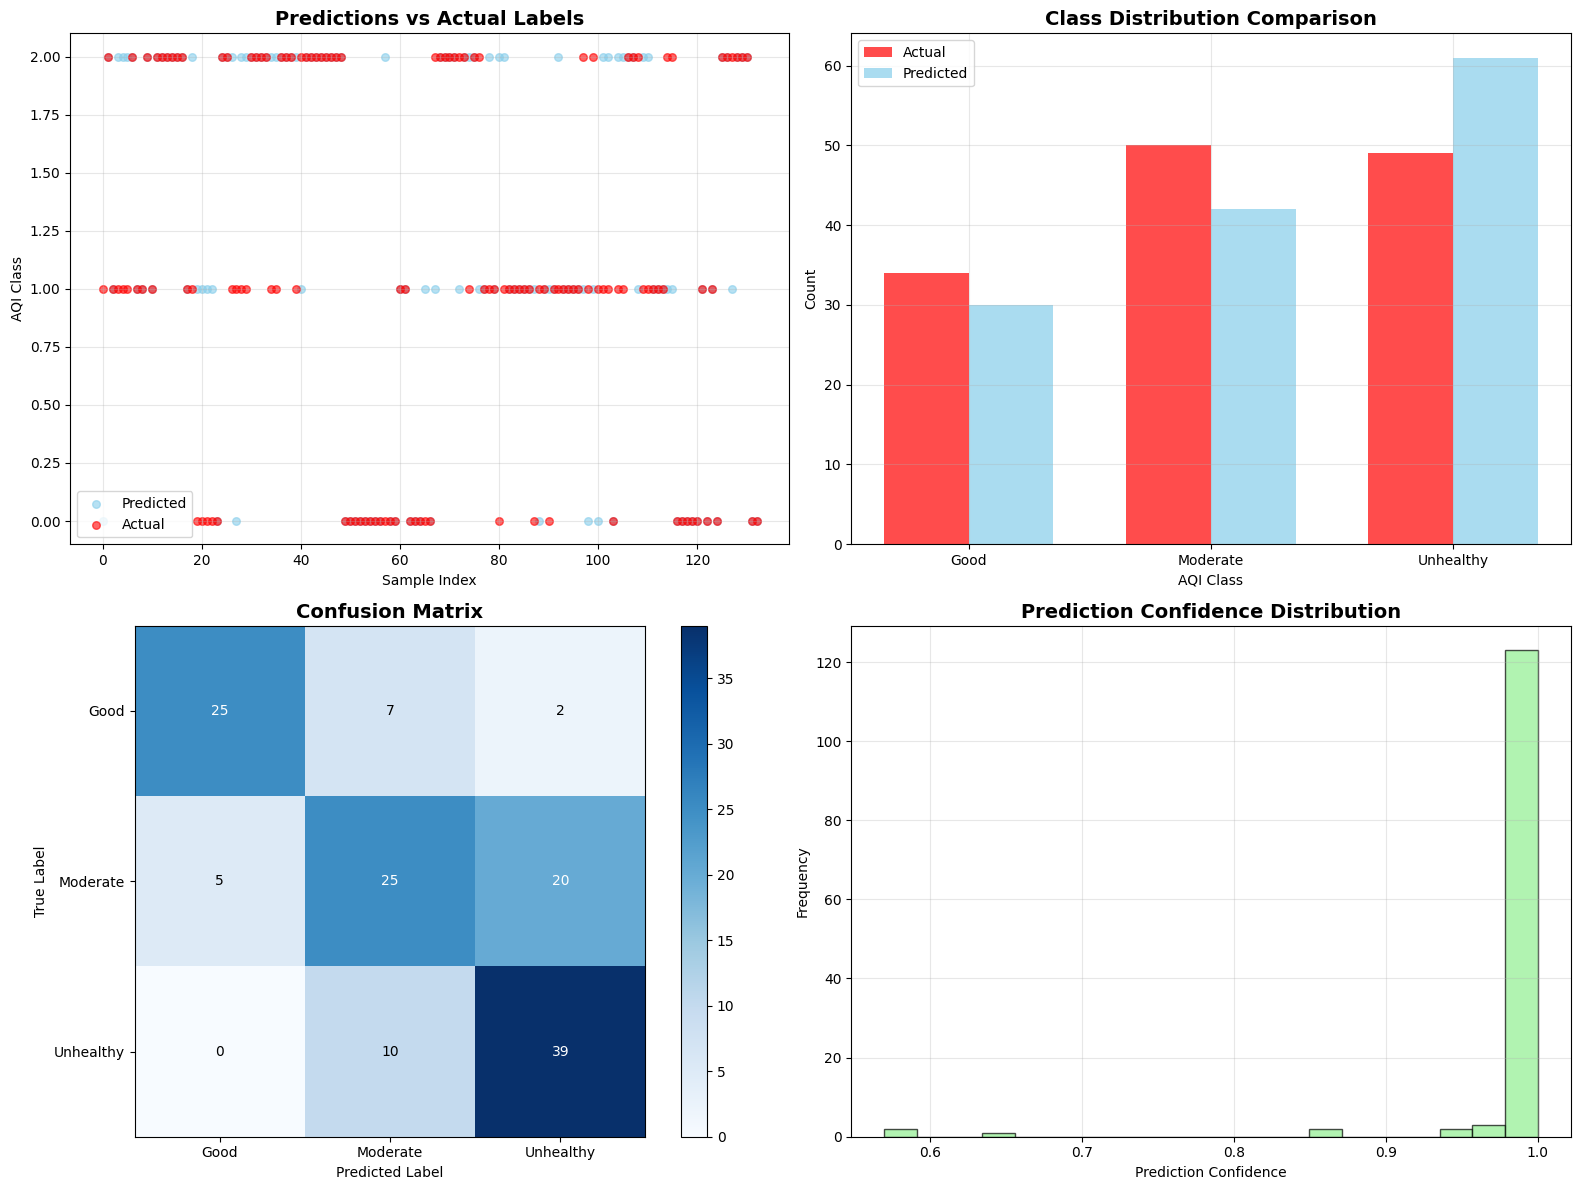


📈 Model Performance Metrics:
Overall Accuracy: 0.6692

Detailed Classification Report:
              precision    recall  f1-score   support

        Good       0.83      0.74      0.78        34
    Moderate       0.60      0.50      0.54        50
   Unhealthy       0.64      0.80      0.71        49

    accuracy                           0.67       133
   macro avg       0.69      0.68      0.68       133
weighted avg       0.67      0.67      0.67       133


🎉 GNN Analysis Complete!

Calculating Mean Squared Error (MSE)...
 Mean Squared Error (MSE): 0.3759


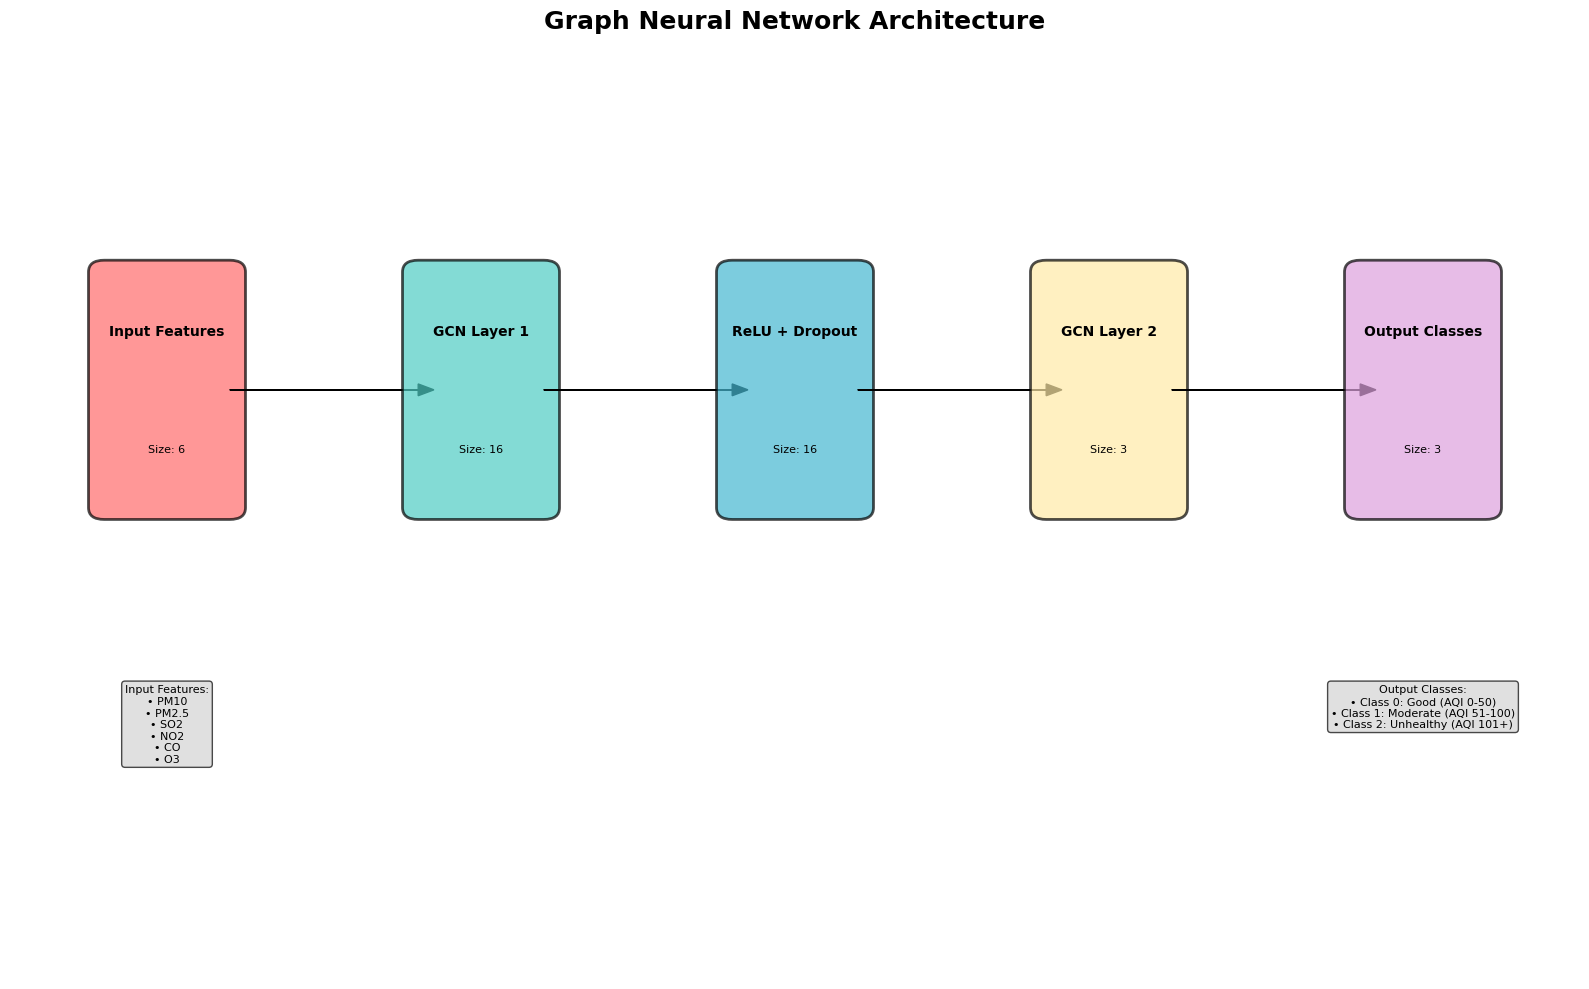

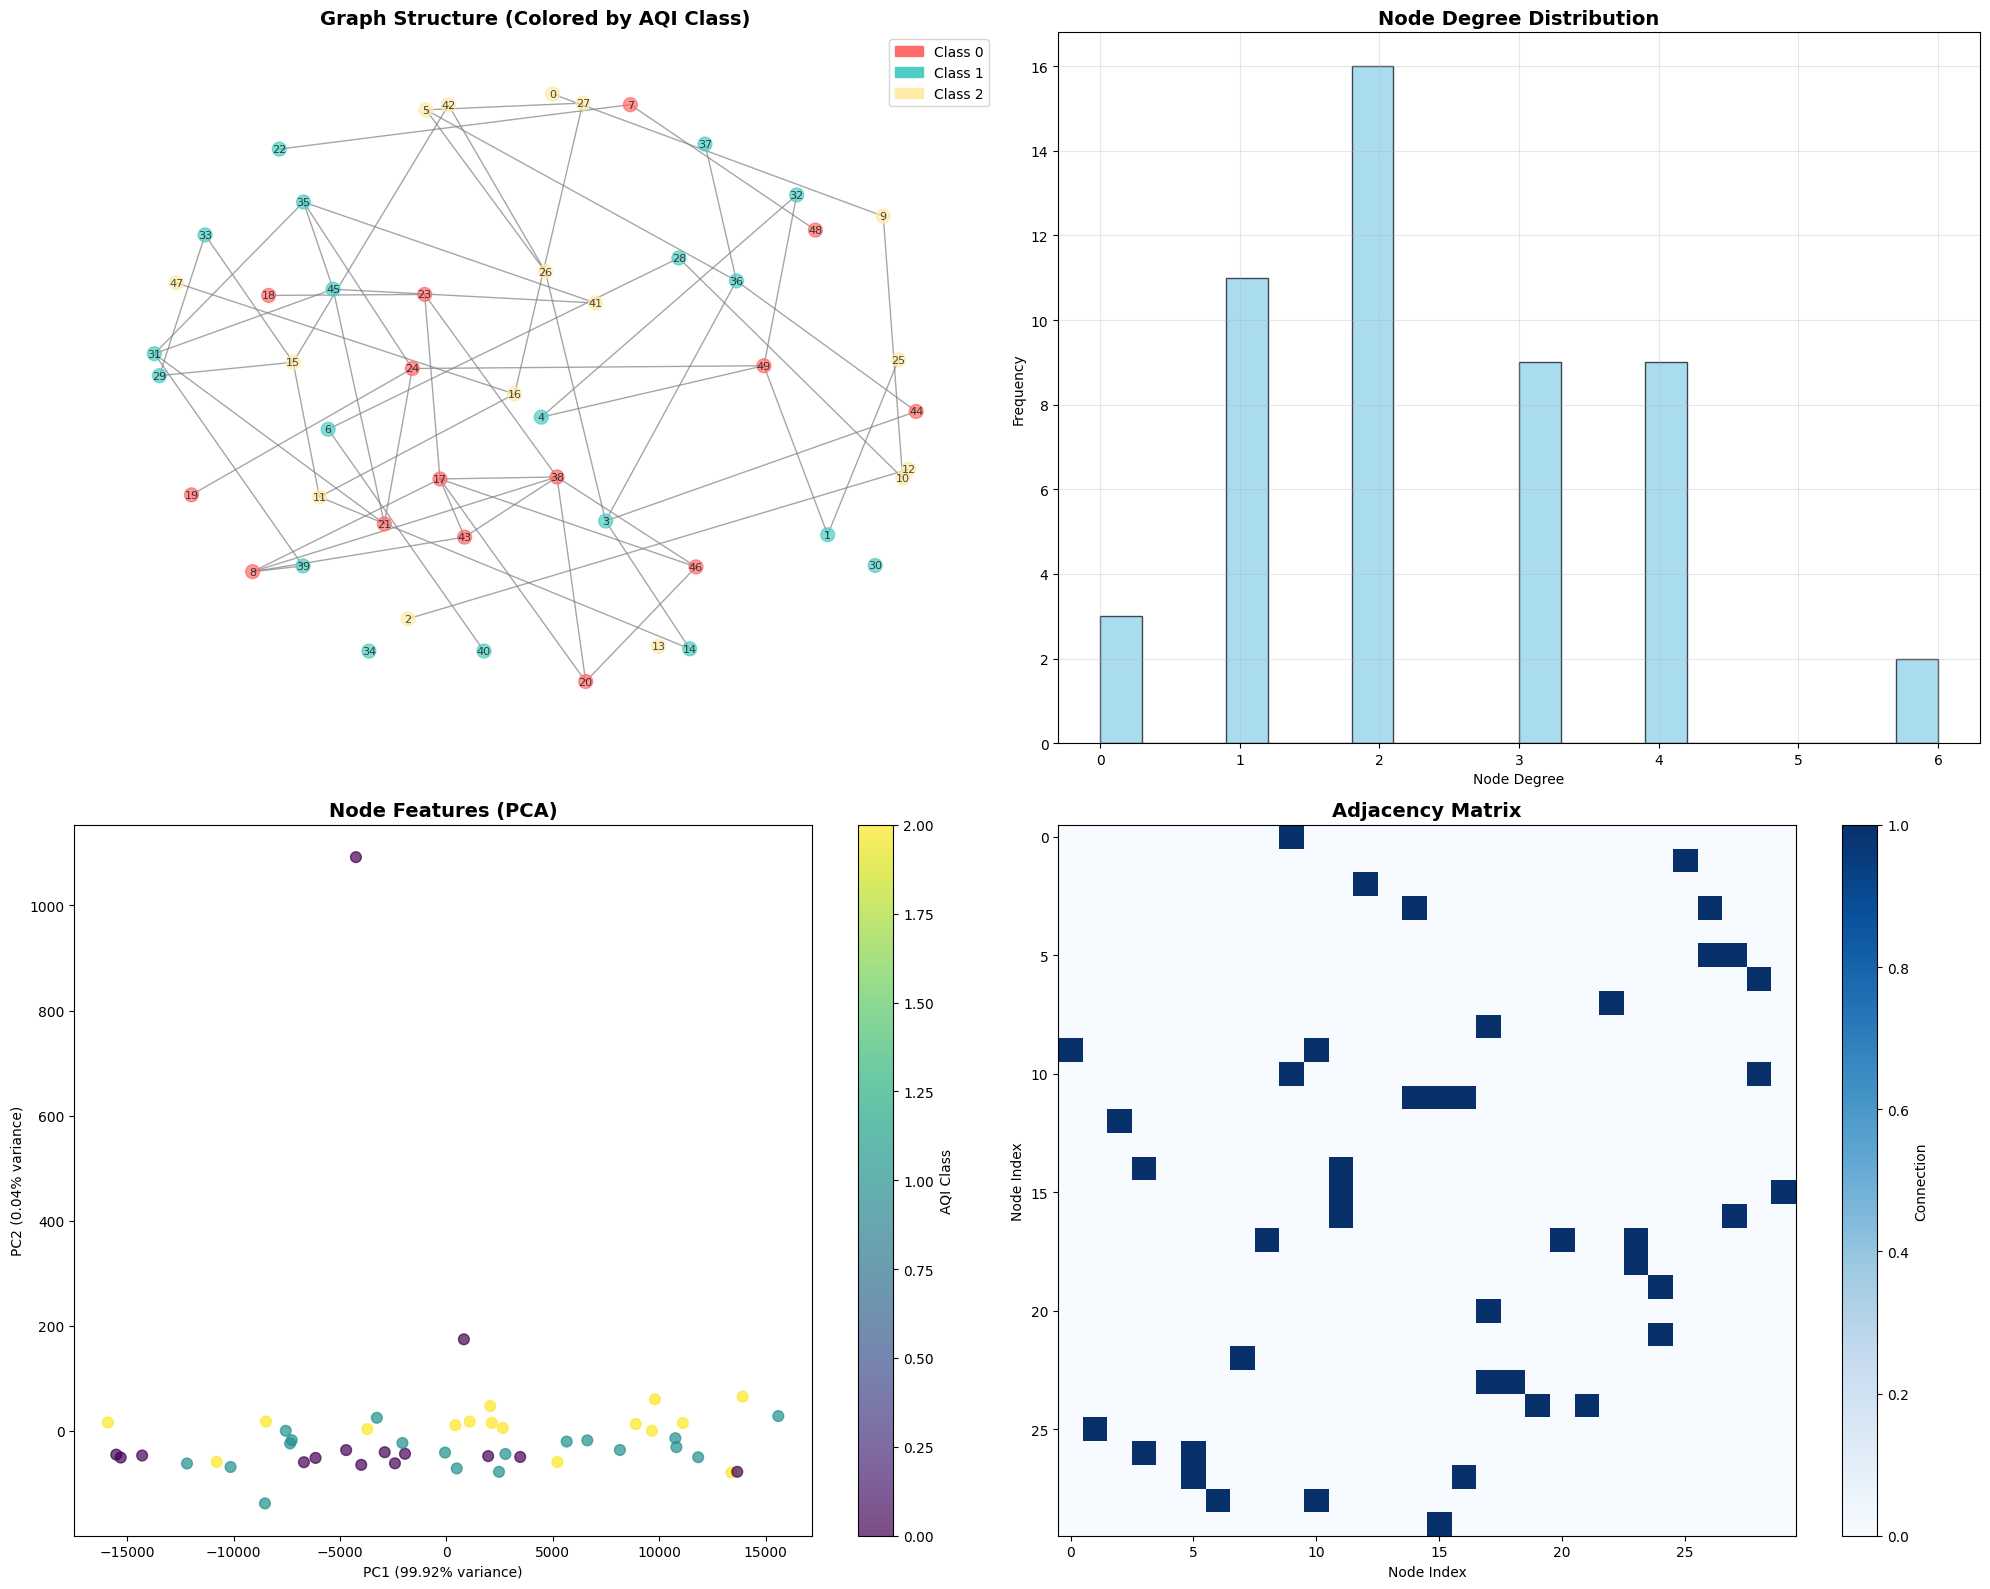


📊 Graph Statistics:
Nodes: 50, Edges: 59
Average degree: 2.36
Density: 0.0482
Connected components: 8


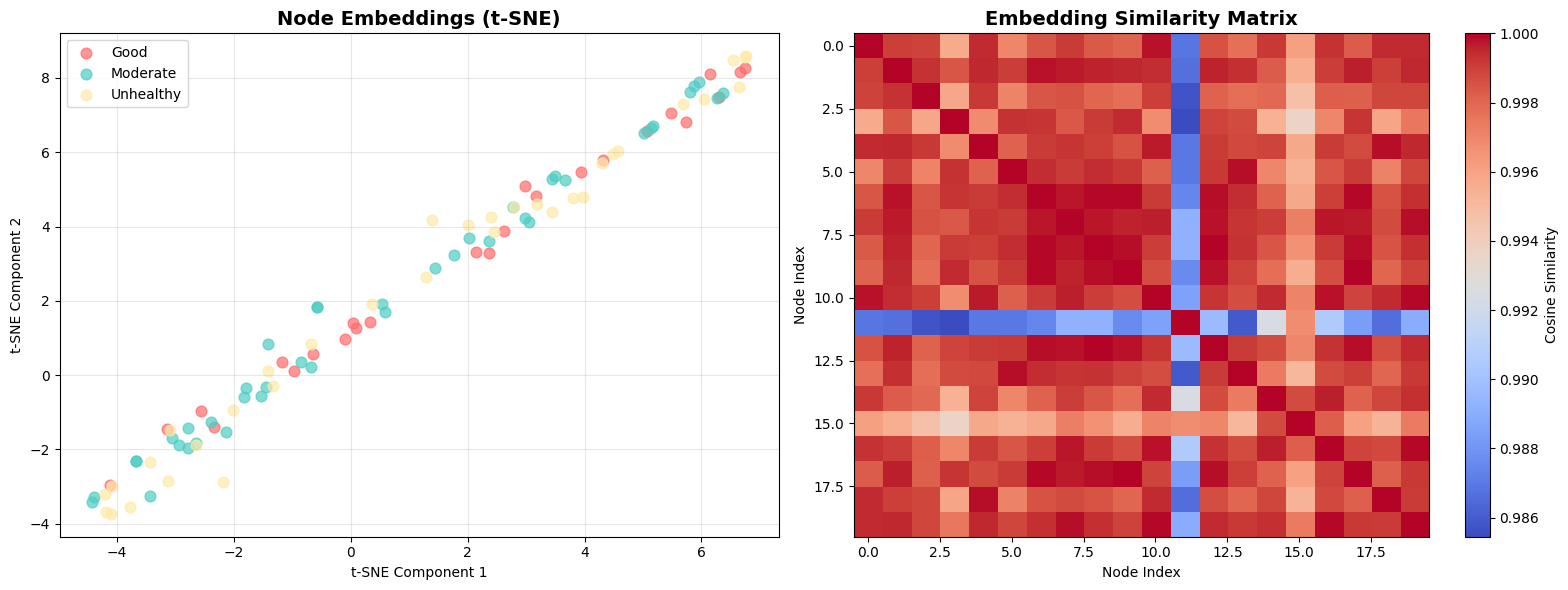

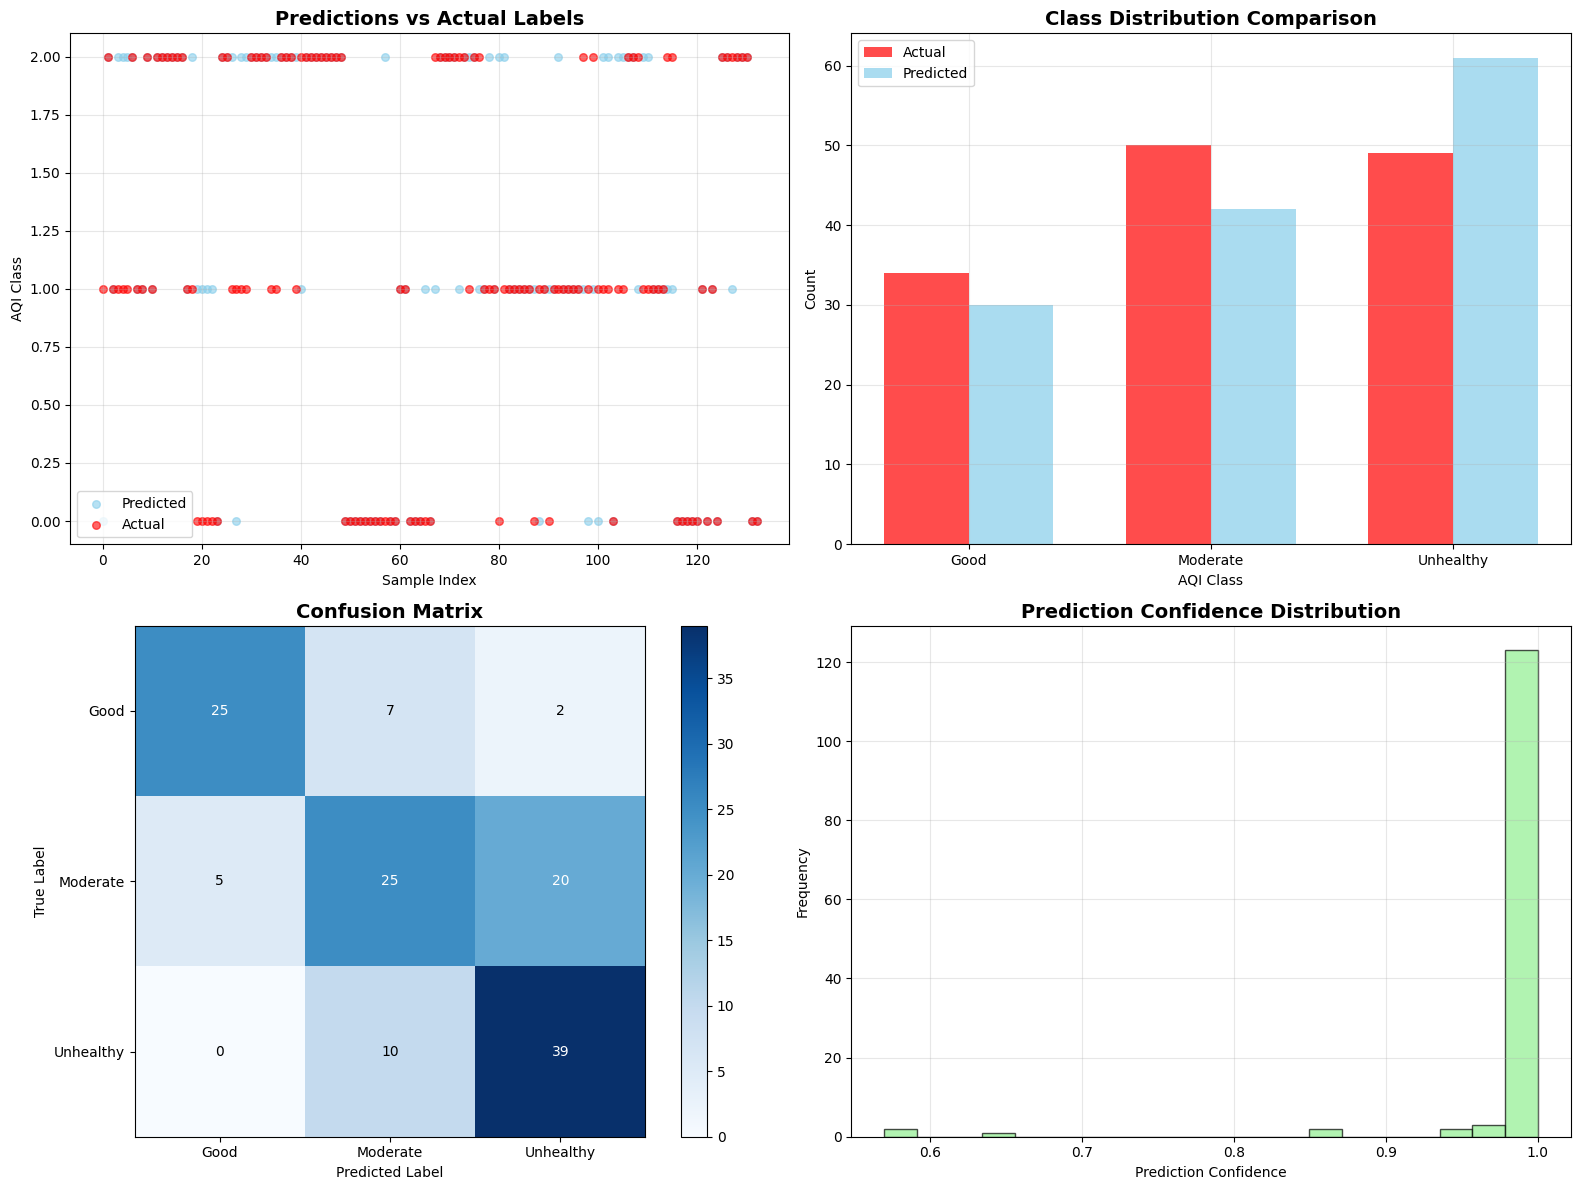


📈 Model Performance Metrics:
Overall Accuracy: 0.6692

Detailed Classification Report:
              precision    recall  f1-score   support

        Good       0.83      0.74      0.78        34
    Moderate       0.60      0.50      0.54        50
   Unhealthy       0.64      0.80      0.71        49

    accuracy                           0.67       133
   macro avg       0.69      0.68      0.68       133
weighted avg       0.67      0.67      0.67       133



In [20]:
# Run the complete analysis
model, data, losses, accs = main_gnn_analysis("AQ-Dataset.csv")

# Or run individual visualizations
visualize_gnn_architecture(['PM10', 'PM2.5', 'SO2', 'NO2', 'CO', 'O3'])
visualize_graph_structure(data)
visualize_node_embeddings(model, data)
visualize_predictions(model, data)